In [53]:
from dataclasses import dataclass

from pandas.io.xml import preprocess_data
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import logging
import textwrap



In [54]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("../logs/preprocessing.log"),
        logging.StreamHandler()
    ]
)

logger=logging.getLogger(__name__)

In [55]:
@dataclass

class Config:
    """Confiuration parameters of the EDA pipeline. """
    RAW_DATA_PATH:str = '../data/raw_data/card_transdata.csv'
    PROCESSED_DATA_PATH:str = '../data/processed_data/card_transdata.csv'
    FIGURES_PATH:str = '../assets/figures/'
    REPORT_PATH:str = '../assets/eda_reports/'
    FIGURE_SIZE:tuple = (16, 12)
    PALETTE:str = 'viridis'
    SEED:int =42
config=Config()

In [56]:
def check_directory(file_path: str) -> None:
    """
    Ensures that directory exists if not then create one
    """
    try:
       if not os.path.exists(file_path):
            os.makedirs(file_path, exist_ok=True)
            logger.info(f'Directory Validated: {file_path}')
       else:
           logger.info(f'Directory Exists: {file_path}')
    except Exception as e:
        logger.error(f'Error in creating the directory {file_path}: {str(e)}')
        raise

In [57]:
def setup_environment() -> None:
    """Initialize the analysis environment """
    np.random.seed(config.SEED)
    sns.set_theme(style='whitegrid', palette=config.PALETTE)
    plt.rcParams['figure.figsize'] = config.FIGURE_SIZE
    check_directory(config.FIGURES_PATH)
    check_directory(config.REPORT_PATH)
    check_directory(os.path.dirname(config.RAW_DATA_PATH))
    check_directory(
        os.path.dirname(config.PROCESSED_DATA_PATH)
    )

In [58]:
def load_validate_data(file_path: str) -> pd.DataFrame:
    try:
        logger.info(f'Loading Data from {file_path}')
        df = pd.read_csv(file_path)
        logger.info(f"Performing data validation checks")
        requried_columns = {'distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order','fraud'
        }

        missing_cols = requried_columns - set(df.columns)
        if missing_cols:
            raise ValueError(f'Missing required columns: {missing_cols}')
        type_checks = {
            'distance_from_home':float,
            'distance_from_last_transaction':float,
            'ratio_to_median_purchase_price':float,
            'repeat_retailer':float,
            'used_chip':float,
            'used_pin_number':float,
            'online_order':float,
            'fraud':float
        }

        for col, expected_type in type_checks.items():
            if not pd.api.types.is_dtype_equal(df[col].dtype, expected_type):
                raise ValueError(f'Column {col} has incorrect type.\nExpected {expected_type}, got {df[col].dtype}')

        #checks missing values
        if df.isnull().sum().sum() > 0:
            missing = df.isnull().sum()
            missing = missing[missing > 0]
            logger.warning(f'Missing values found:\n{missing}')


        #check sentiment categories
        valid_fraud_val = {0,1}
        invalid_fraud_val = set(df['fraud'].unique()) - valid_fraud_val

        if invalid_fraud_val:
            logger.warning(f'Unexpected fraud categories found: {invalid_fraud_val}')

        logger.info('Data validation is completed successfully')
        return df
    except Exception as e:
        logger.error(f'Data loading/validation failed: {str(e)}')

In [59]:

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Scaled the data using StandardScaler and save it to ../data/processed_data/card_transdata.csv.
    :param data: Pandas DataFrame, contains the data
    :return:pd.DataFrame
    '''
    logger.info('Feature Engineering')
    scalerstd=StandardScaler()
    colums_to_scale=['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order']
    data[colums_to_scale]=scalerstd.fit_transform(data[colums_to_scale])
    logger.info('Feature Engineering Completed')
    joblib.dump(scalerstd,'../weights/scaler/scaler.pkl')
    logger.info('Scaler Saved')
    return data


In [60]:
# Now let's plot some important graphs to understand the dataset

def plot_dataset_overview(data: pd.DataFrame) -> None:
    '''
    Plot important graphs to understand the dataset
    '''
    logger.info('Plotting Dataset Overview')

    try:
        plt.subplot(2, 2, 1)
        sns.countplot(x='fraud', data=data)
        plt.title('Fraud vs Non-Fraud Count')
        plt.xlabel('Fraud')
        plt.ylabel('Count')


        plt.subplot(2, 2, 2)
        sns.histplot(data=data, x='distance_from_home', hue='fraud', bins=50, kde=True, multiple='stack')
        plt.title('Distance from Home Distribution')


        plt.subplot(2, 2, 3)
        sns.histplot(data=data, x='distance_from_last_transaction', hue='fraud', bins=50, kde=True, multiple='stack')
        plt.title('Distance from Last Transaction Distribution')


        plt.subplot(2, 2, 4)
        sns.histplot(data=data, x='ratio_to_median_purchase_price', hue='fraud', bins=50, kde=True, multiple='stack')
        plt.title('Ratio to Median Purchase Price Distribution')

        plt.tight_layout()
        plt.savefig('../assets/figures/dataset_overview.png')
    except Exception as e:
        logger.error(f'Error in plotting dataset overview: {str(e)}')

In [61]:
# Let's create a correlation heatmap and pairplot for deeper understanding

def plot_correlation_and_pairplot(data: pd.DataFrame) -> None:
    '''
    Plot correlation heatmap and pairplot to understand feature relationships
    :param data: pd.DataFrame, contains the data
    :return: None
    '''
    logger.info('Plotting Correlation and Pairplot')
    try:
        # 1. Correlation heatmap
        plt.figure(figsize=(10, 8))
        corr = data.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Feature Correlation Heatmap')
        plt.savefig('../assets/figures/correlation_heatmap.png')
        plt.show()

        # 2. Pairplot
        plt.figure(figsize=(14, 14))
        selected_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price','online_order', 'fraud']
        pairplot = sns.pairplot(
            data[selected_features],
            hue='fraud',
            palette='husl',
            diag_kind='kde',
            corner=True,
            height=4,
            aspect=1.2   # width/height ratio
        )

        pairplot.fig.suptitle('Pairplot of Selected Features Colored by Fraud', y=1.02, fontsize=20)

        pairplot.fig.savefig('../assets/figures/pairplot.png')
    except Exception as e:
        logger.error(f'Error in plotting correlation and pairplot: {str(e)}')


In [62]:
def generate_eda_report(df: pd.DataFrame) -> None:
    """Generate a comprehensive EDA report """
    logger.info("Generating EDA report")

    try:
        report_path = os.path.join(config.REPORT_PATH, 'eda_report.txt')

        with open(report_path, 'w') as f:
            f.write("="*80 + "\n")
            f.write("COMPREHENSIVE EDA REPORT - CREDIT CARD FRAUD\n")
            f.write(f"Columns: {', '.join(df.columns)}\n\n")


            #data quality
            f.write("2. DATA QUALITY CHECK\n")
            f.write("-"*40 + "\n")
            f.write("Missing Values: \n")
            missing = df.isnull().sum()
            missing = missing[missing > 0]
            if len(missing) > 0:
                for col, count in missing.items():
                    f.write(f" - {col}: {count} ({count/len(df):.1%})\n")
            else:
                f.write("  No missing values found\n")

            #basics statistics
            f.write("\n3: BASIC STATISTICS\n")
            f.write("-"*40 + "\n")
            f.write("Numerical Features:\n")
            f.write(textwrap.indent(df.describe().to_string(),"  "))
            f.write("\n\nCategorical Features:\n")
            f.write(textwrap.indent(df.describe(include='object').to_string(),"  "))


            #sentiment analysis
            f.write("\n\n4. FRAUD ANALYSIS\n")
            f.write("-"*40 + "\n")
            fraud_counts = df['fraud'].value_counts()
            f.write("fraud distribution:\n")
            for sentiment, count in fraud_counts.items():
                f.write(f"  - {sentiment}: {count} ({count/len(df):.1%})\n")

            # Key insights
            f.write("\n5. KEY INSIGHTS\n")
            f.write("-"*40 + "\n")
            f.write(f"- Fraud to Non fraud ratio: {(df['fraud']==1).sum()/(df['fraud']==0).sum()}\n")


        logger.info(f"EDA report saved to {report_path}")

    except Exception as e:
        logger.error(f"Error generating EDA report: {str(e)}")


In [63]:
def save_plot(fig: plt.Figure, plot_name: str, plot_dir: str = '../assets/figures') -> None:
    try:
        os.makedirs(plot_dir, exist_ok=True) #Create the directory if not exists
        plot_path = os.path.join(plot_dir, plot_name)
        fig.savefig(plot_path, bbox_inches='tight')
        plt.close(fig)
        logger.info(f"Plot saved successfully: {plot_path}")

    except Exception as e:
        logger.error(f"Failed to save plot {plot_name}: {str(e)}")


In [64]:
# Main Analysis Pipeline
def perform_eda() -> None:
    """Execute the complete EDA pipeline."""
    try:
        logger.info("Starting EDA pipeline")
        setup_environment()

        # Load and validate data
        df = load_validate_data(config.RAW_DATA_PATH)

        # Feature engineering
        df = feature_engineering(df)

        # Comprehensive EDA

        plot_dataset_overview(df)
        plot_correlation_and_pairplot(df)

        # Generate reports
        generate_eda_report(df)

        # Save processed data
        df.to_csv(config.PROCESSED_DATA_PATH, index=False)
        logger.info(f"Processed data saved to {config.PROCESSED_DATA_PATH}")

        logger.info("EDA pipeline completed successfully")

    except Exception as e:
        logger.error(f"EDA pipeline failed: {str(e)}")
        raise

2025-05-01 07:15:58,830 [INFO] Starting EDA pipeline
2025-05-01 07:15:58,831 [INFO] Directory Exists: ../assets/figures/
2025-05-01 07:15:58,832 [INFO] Directory Exists: ../assets/eda_reports/
2025-05-01 07:15:58,832 [INFO] Directory Exists: ../data/raw_data
2025-05-01 07:15:58,832 [INFO] Directory Exists: ../data/processed_data
2025-05-01 07:15:58,832 [INFO] Loading Data from ../data/raw_data/card_transdata.csv
2025-05-01 07:15:59,287 [INFO] Performing data validation checks
2025-05-01 07:15:59,297 [INFO] Data validation is completed successfully
2025-05-01 07:15:59,298 [INFO] Feature Engineering
2025-05-01 07:15:59,353 [INFO] Feature Engineering Completed
2025-05-01 07:15:59,354 [INFO] Scaler Saved
2025-05-01 07:15:59,354 [INFO] Plotting Dataset Overview
2025-05-01 07:15:59,715 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-01 0

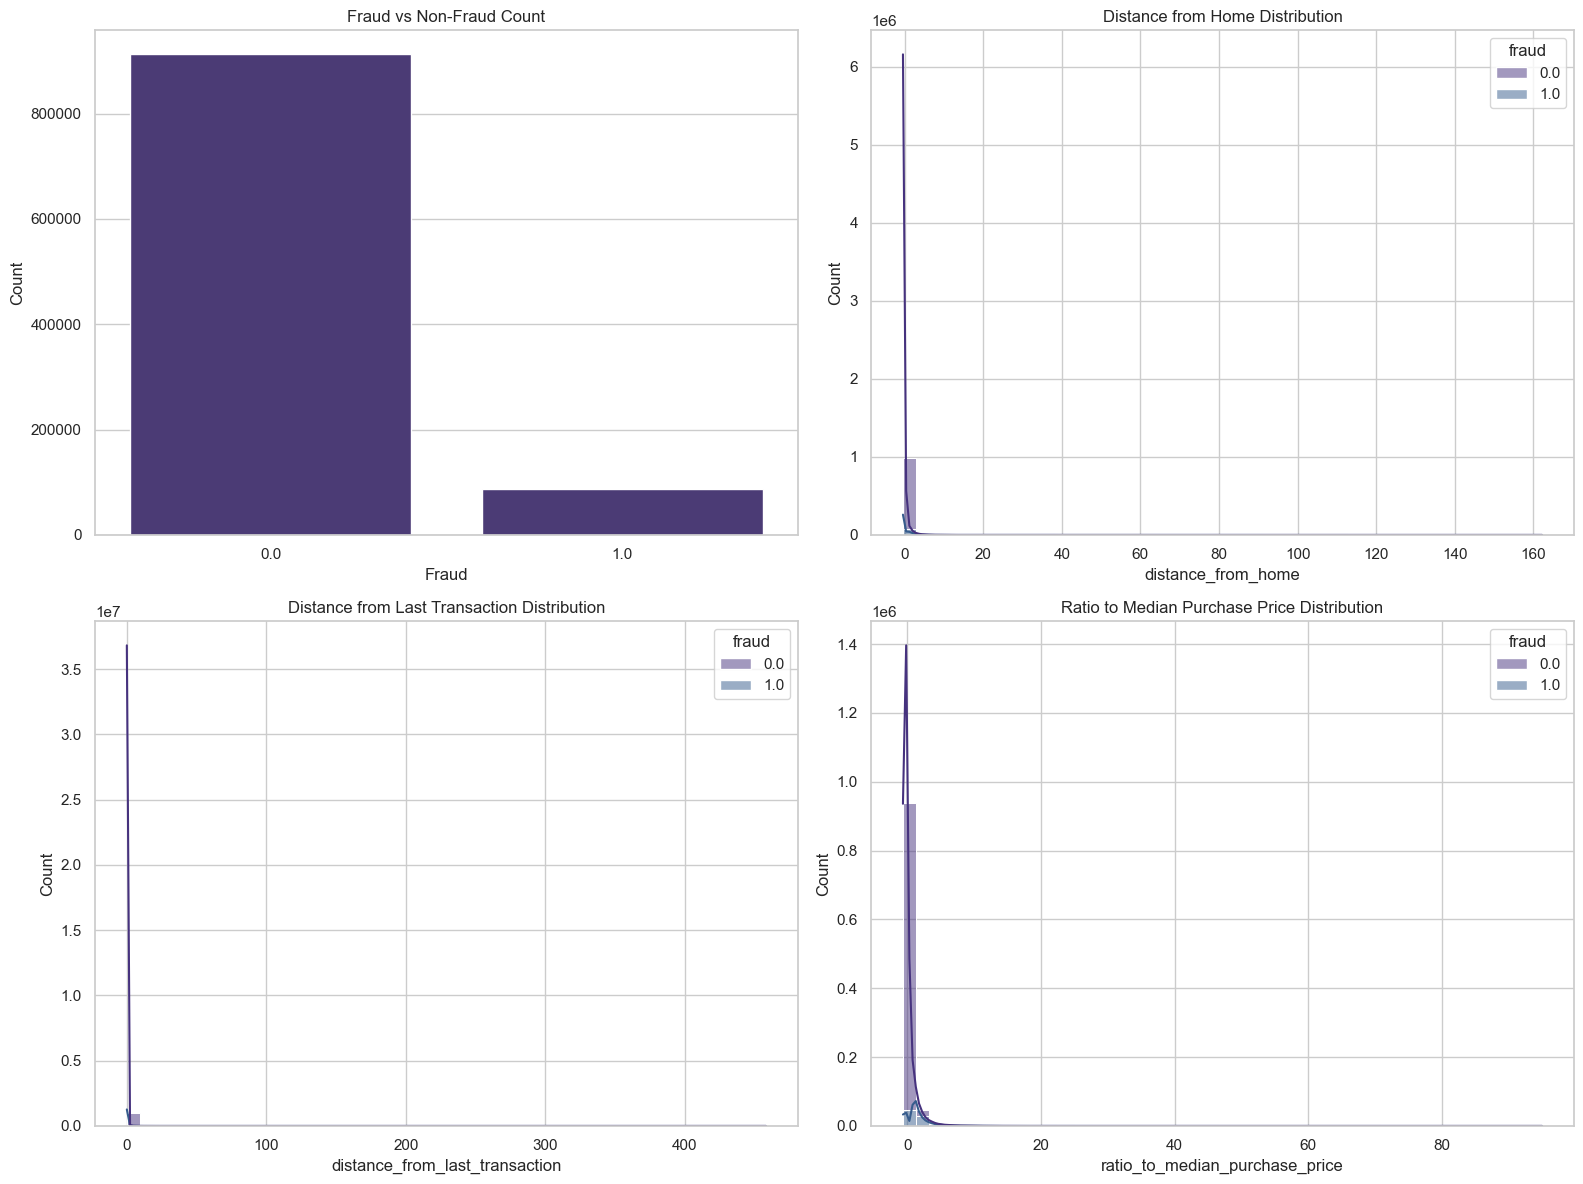

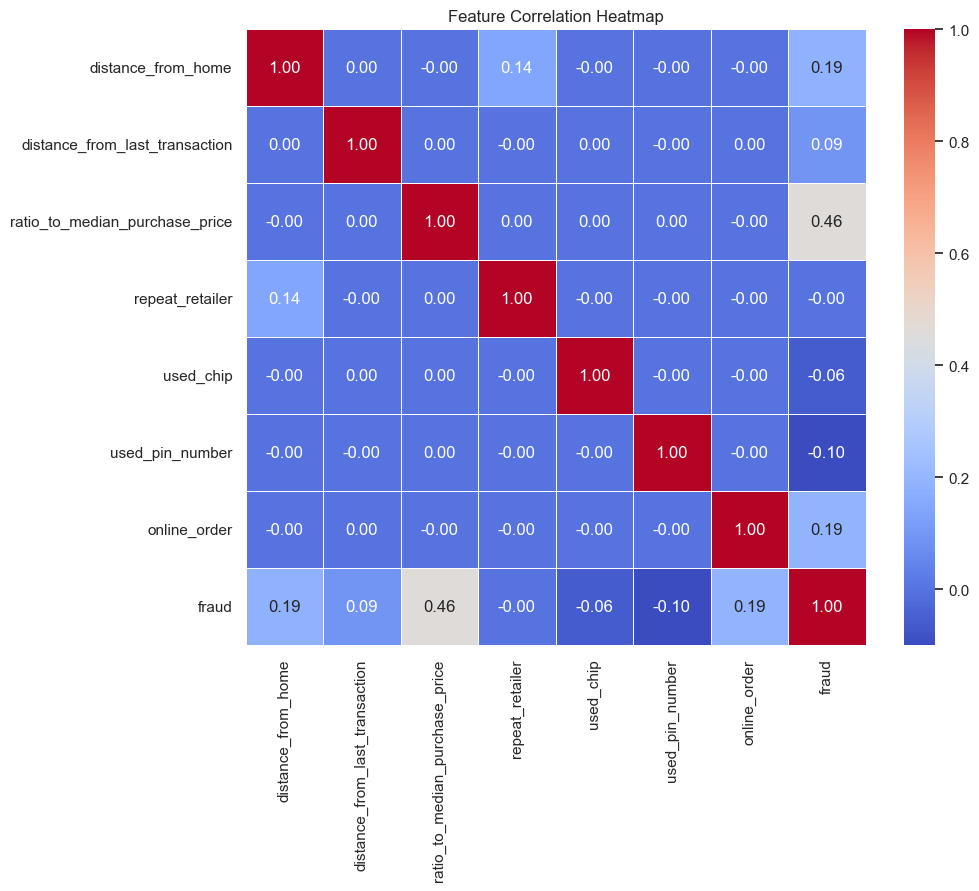

2025-05-01 07:18:23,887 [INFO] Generating EDA report
2025-05-01 07:18:24,039 [ERROR] Error generating EDA report: No objects to concatenate
2025-05-01 07:18:30,009 [INFO] Processed data saved to ../data/processed_data/card_transdata.csv
2025-05-01 07:18:30,010 [INFO] EDA pipeline completed successfully


<Figure size 1400x1400 with 0 Axes>

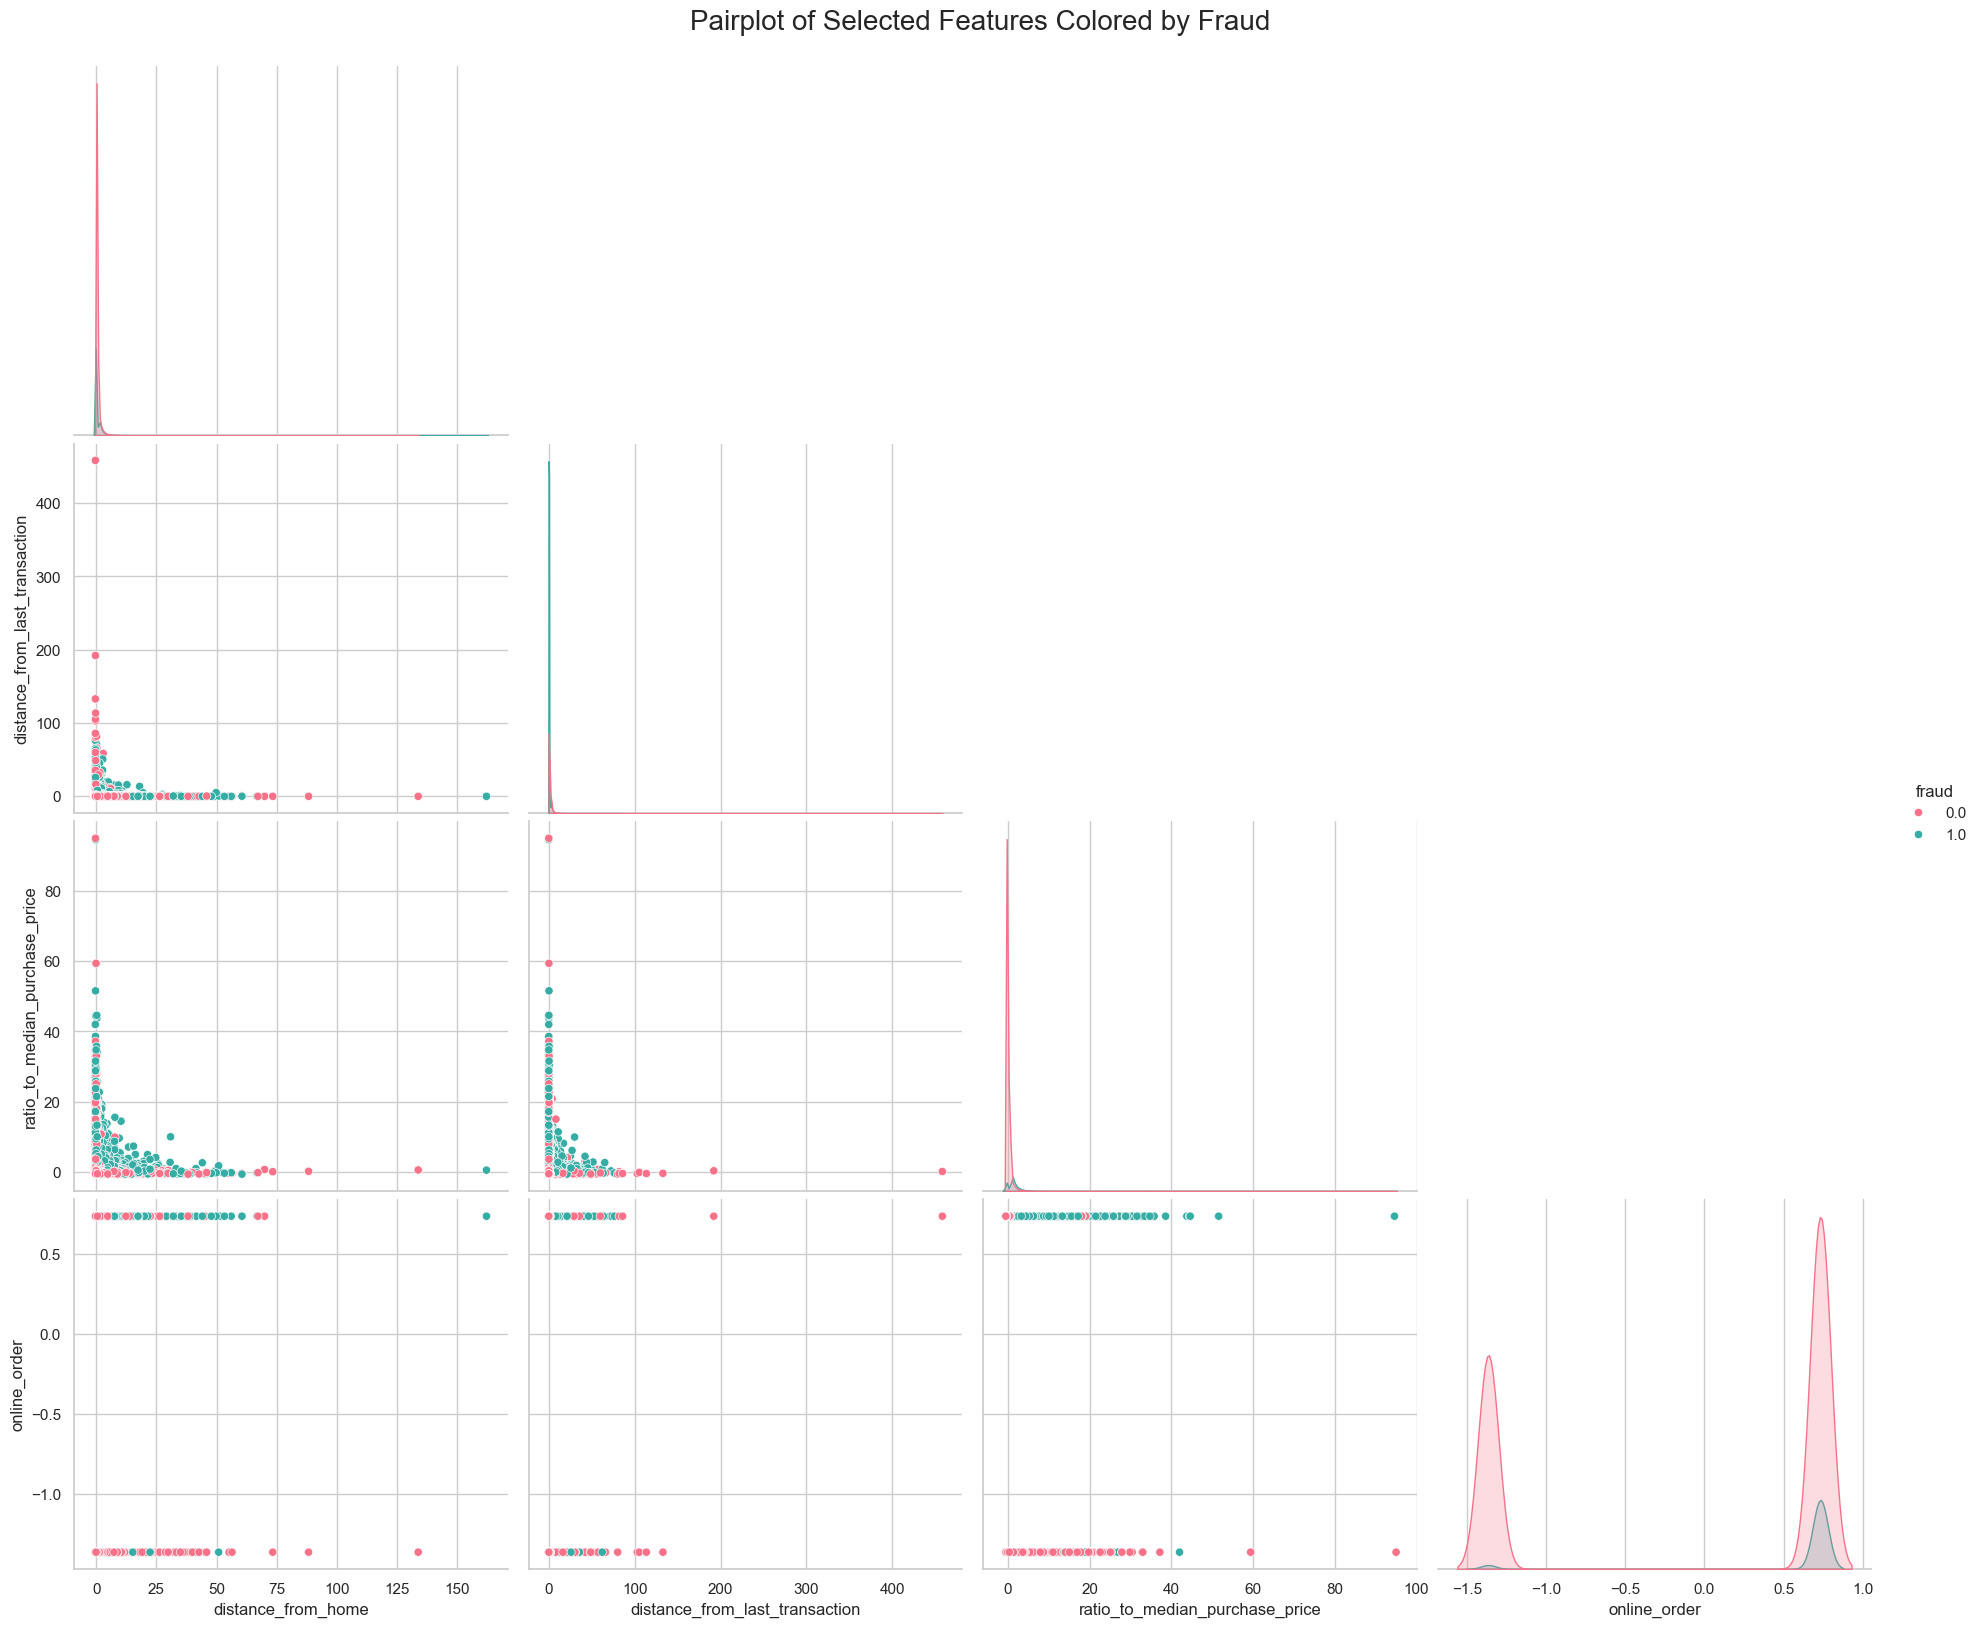

In [65]:
perform_eda()